# Resnet Clustering

This notebook will use a pretrained (on imagenet) resnet 34 model and then perform K-Means clustering on this.

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 34.0MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [0]:
from fastai import *
import torch
from torch import nn
import imageio
from fastai.vision import *
import os
import torch.nn.functional as F
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
%cd "/content/drive/My Drive/automatic-asset-classification"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/automatic-asset-classification


In [4]:
np.random.seed(3333)
torch.manual_seed(3333)
image_path = "/content/drive/My Drive/automatic-asset-classification/data/final_dataset"
size = 224
batchsize = 32

tfms = get_transforms(do_flip = True)
src = (ImageList.from_folder(image_path).split_by_rand_pct().label_from_folder())
data = (src.transform(tfms, size=size, resize_method=ResizeMethod.CROP)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats))
print("imported")

imported


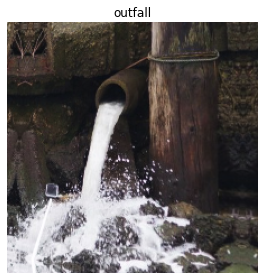

In [5]:
data.show_batch(rows=1)

## Clustering

Due to the other methods requiring training, this method will only use the validation set also for clustering.

In [0]:
class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class ResnetEncoder(nn.Module):
    def __init__(self):
        super(ResnetEncoder, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', 
                                pretrained = True)
        resnet = nn.Sequential(*(list(resnet.children())[:-2]))
        for param in resnet.parameters():
            param.requires_grad = False

        self.feature_extract = resnet

        self.ConcatPool2D = AdaptiveConcatPool2d()

    def forward(self,x):
        x = self.feature_extract(x)
        x = self.ConcatPool2D(x)
        return x.squeeze()


In [7]:
encoder = ResnetEncoder()
learn = Learner(data, encoder, metrics=error_rate, loss_func = F.mse_loss)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [8]:
preds, acts = learn.get_preds()

In [9]:
len(preds)

110

In [0]:
cluster_data = preds.numpy()

In [0]:
cluster_data_st = (cluster_data - cluster_data.mean())/cluster_data.std()

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(cluster_data_st, method = 'ward')

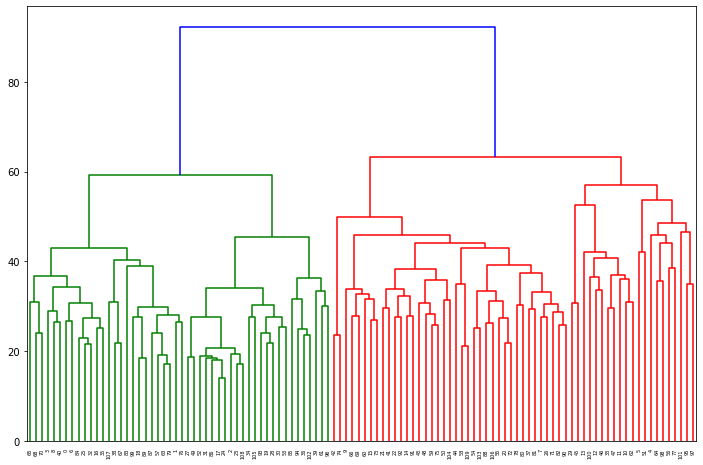

In [17]:
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [19]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit(cluster_data_st)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

In [0]:
clusters = cluster.fit_predict(cluster_data_st)

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data)
X_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data)
X_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data)

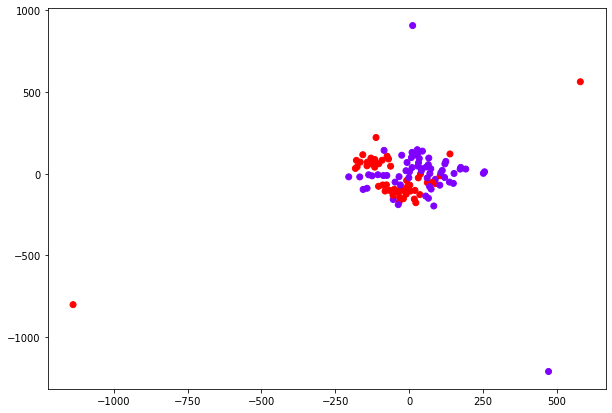

In [23]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_, cmap='rainbow')

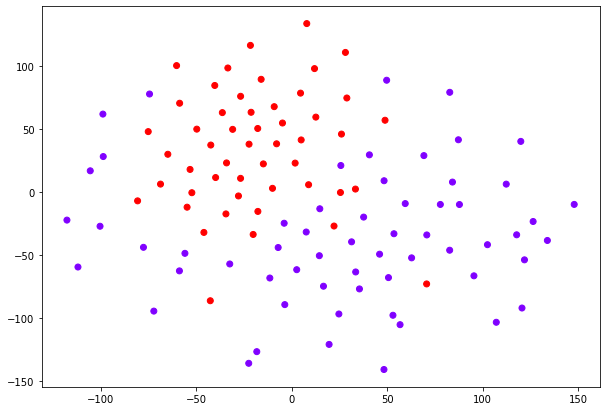

In [24]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

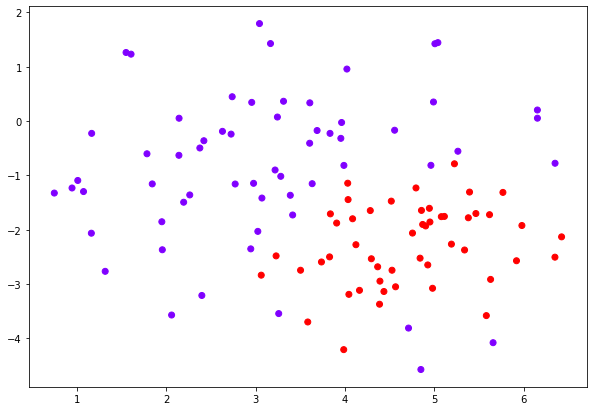

In [25]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
cluster_data_pca = pca.fit_transform(cluster_data_st)

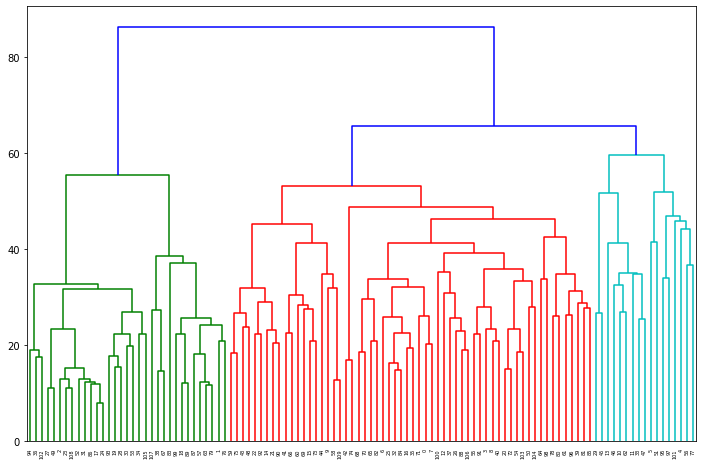

In [28]:
linked = linkage(cluster_data_pca, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [0]:
X_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data_pca)
X_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_pca)
X_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data_pca)

In [0]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters=cluster.fit_predict(cluster_data_pca)

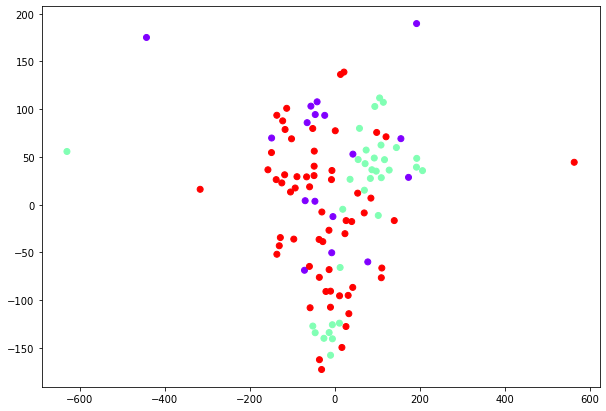

In [32]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_, cmap='rainbow')

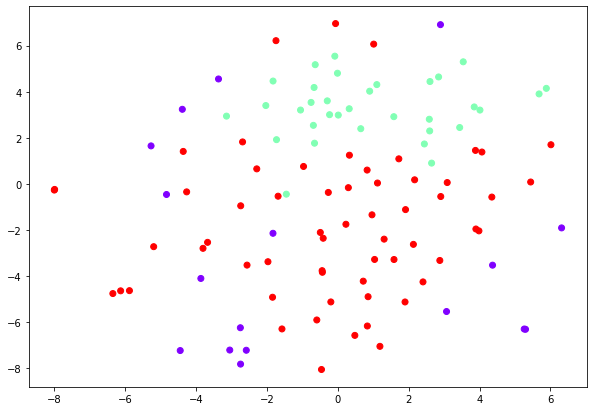

In [33]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

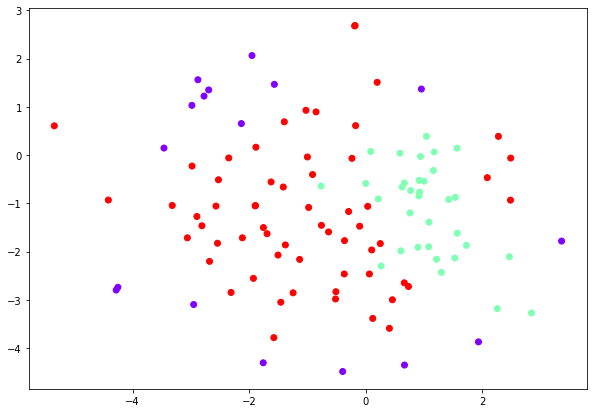

In [34]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

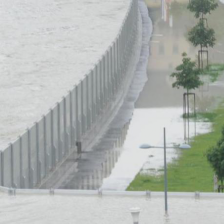

In [42]:
data.valid_ds[0][0]

In [0]:
ones=[]
twos=[]
threes=[]
for i in range(len(clusters)):
  if clusters[i] == 0:
    ones.append(int(acts[i]))
  if clusters[i] == 1:
    twos.append(int(acts[i]))
  if clusters[i] == 2:
    threes.append(int(acts[i]))

In [49]:
set(ones), set(twos), set(threes)

({0, 2, 3, 4}, {0, 3, 4}, {0, 1, 2, 3, 4, 5})

In [51]:
data.classes

['embankment', 'flood_gate', 'flood_wall', 'outfall', 'reservoir', 'weir']

In [0]:
one_idx = []
two_idx = []
three_idx = []

for i in range(len(clusters)):
  if clusters[i] == 0:
    one_idx.append(i)
  if clusters[i] == 1:
    two_idx.append(i)
  if clusters[i] == 2:
    three_idx.append(i)

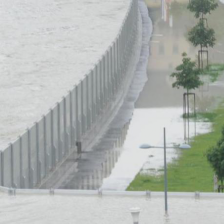

In [55]:
data.valid_ds[three_idx[0]][0]

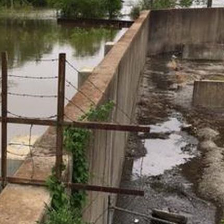

In [56]:
data.valid_ds[three_idx[10]][0]

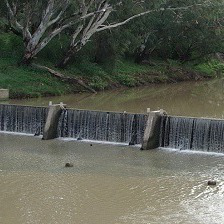

In [57]:
data.valid_ds[three_idx[20]][0]

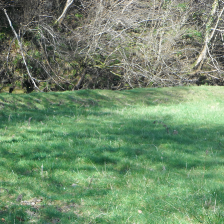

In [58]:
data.valid_ds[two_idx[0]][0]

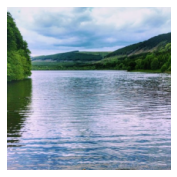

In [66]:
data.valid_ds[two_idx[10]][0].show()

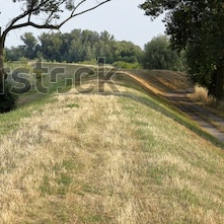

In [60]:
data.valid_ds[two_idx[20]][0]

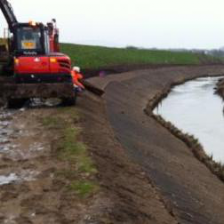

In [61]:
data.valid_ds[one_idx[0]][0]

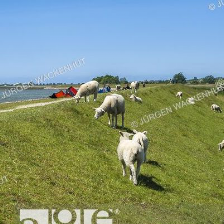

In [62]:
data.valid_ds[one_idx[10]][0]

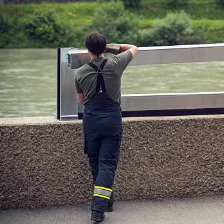

In [64]:
data.valid_ds[one_idx[15]][0]

In [0]:
for idx in three_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_encoder/class3/"+str(idx)+".png")

In [0]:
for idx in two_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_encoder/class2/"+str(idx)+".png")

In [0]:
for idx in one_idx:
  data.valid_ds[idx][0].save("/content/drive/My Drive/automatic-asset-classification/outputs/resnet_encoder/class1/"+str(idx)+".png")

In [71]:
%ls

ae_res_1_new    ae_res_3_new    ae_res_4_torch  ae_res_6_torch       models/
ae_res_1_torch  ae_res_3_torch  ae_res_5_new    basic_animation.mp4  test.png
ae_res_2_new    ae_res_4_new    ae_res_5_torch  data/
ae_res_2_torch  ae_res_4-new    ae_res_6_new    final_model


In [0]:
X_embedded = TSNE(n_components=2, perplexity = 5).fit_transform(cluster_data)
X_embedded2 = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data)
X_embedded3 = TSNE(n_components=2, perplexity = 50).fit_transform(cluster_data)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

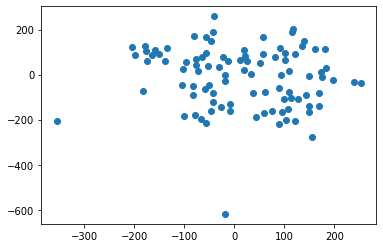

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

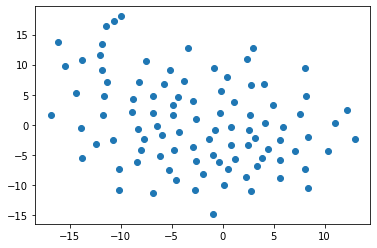

In [0]:
plt.scatter(X_embedded2[:,0], X_embedded2[:,1])

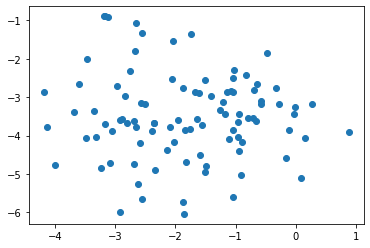

In [0]:
plt.scatter(X_embedded3[:,0], X_embedded3[:,1])

In [0]:
kmeans = KMeans(n_clusters=5, max_iter=1000).fit(cluster_data)
clusters = kmeans.labels_

In [0]:
kmeans2 = KMeans(n_clusters=3, max_iter=1000).fit(cluster_data)
clusters2 = kmeans2.labels_

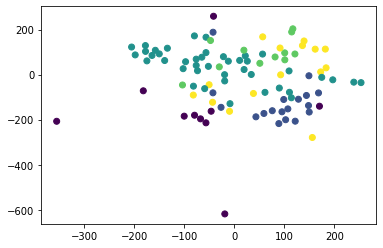

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusters)

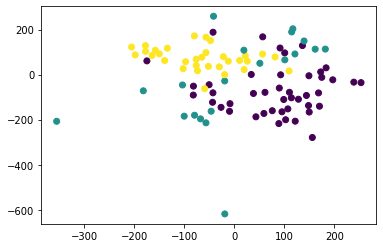

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusters2)

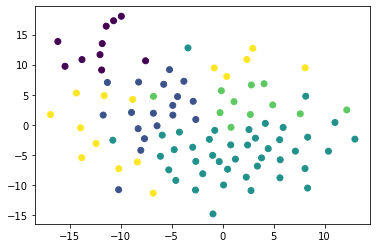

In [0]:
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=clusters)

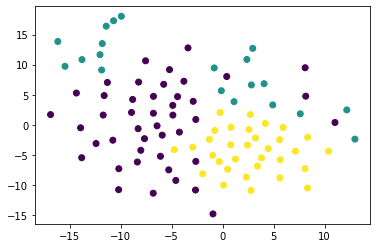

In [0]:
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=clusters2)

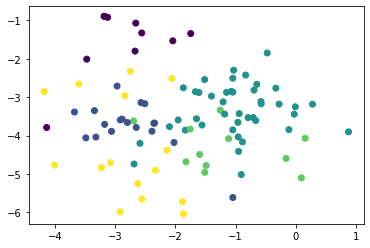

In [0]:
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=clusters)

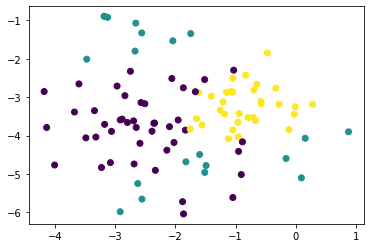

In [0]:
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=clusters2)

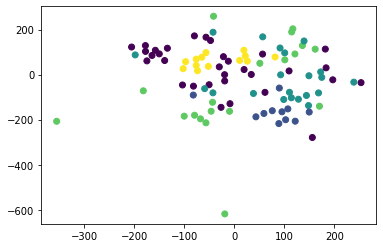

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=acts.numpy())

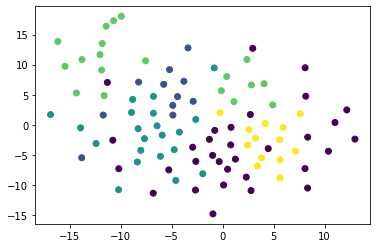

In [0]:
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=acts.numpy())

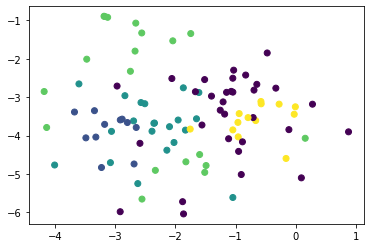

In [0]:
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=acts.numpy())

In [0]:
kmeans3 = KMeans(n_clusters=10, max_iter=1000).fit(cluster_data)
clusters3 = kmeans3.labels_

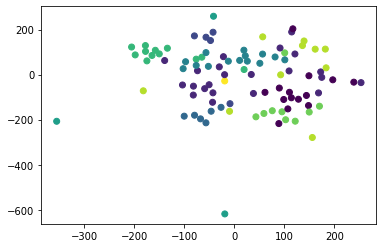

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusters3)

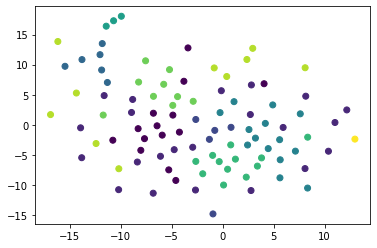

In [0]:
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=clusters3)

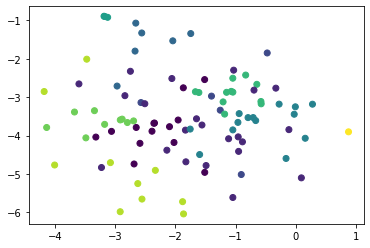

In [0]:
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=clusters3)

In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(cluster_data, method = 'ward')

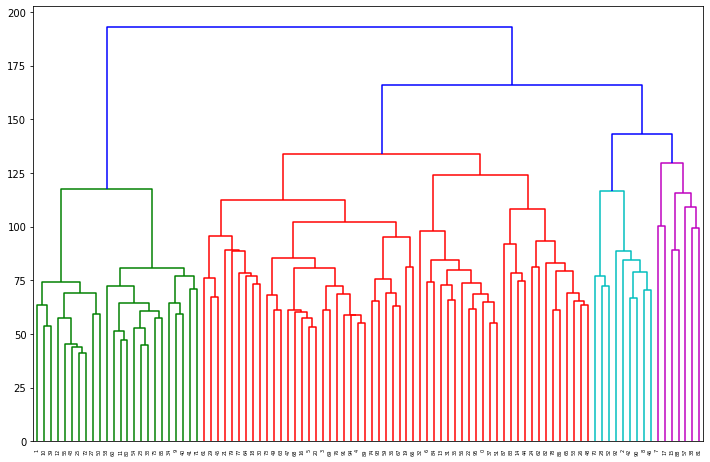

In [0]:
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [0]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit(cluster_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5)

In [0]:
clusters = cluster.fit_predict(cluster_data)

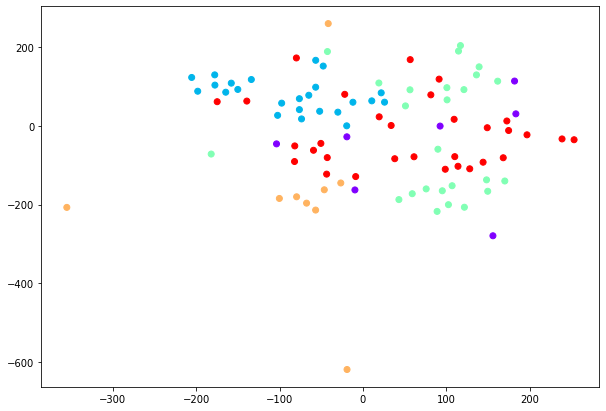

In [0]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cluster.labels_, cmap='rainbow')

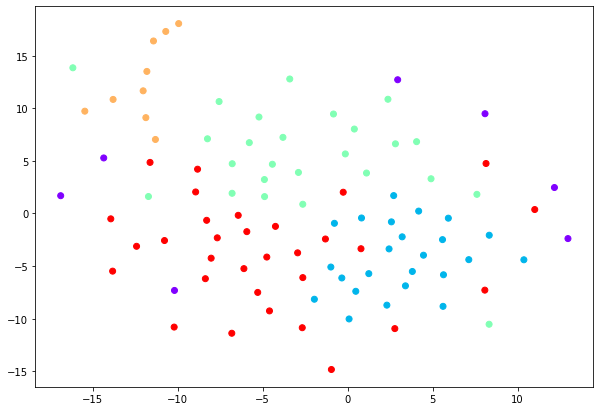

In [0]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded2[:,0], X_embedded2[:,1], c=cluster.labels_, cmap='rainbow')

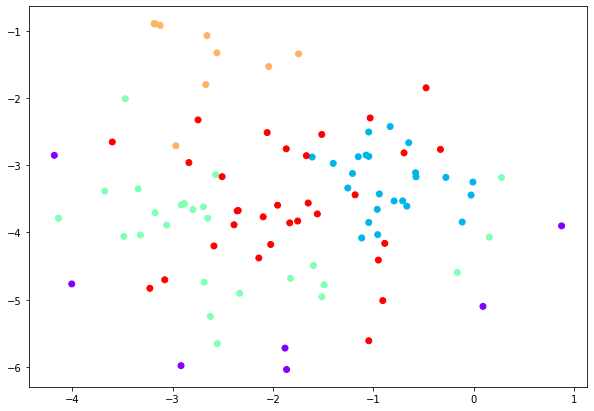

In [0]:
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded3[:,0], X_embedded3[:,1], c=cluster.labels_, cmap='rainbow')

In [0]:
cluster_data.shape

(96, 1024)

In [0]:
cluster_data_std = (cluster_data - np.mean(cluster_data, axis = 0))/np.std(cluster_data, axis = 0)

In [0]:
X_embedded = TSNE(n_components=2, perplexity = 30).fit_transform(cluster_data_std)

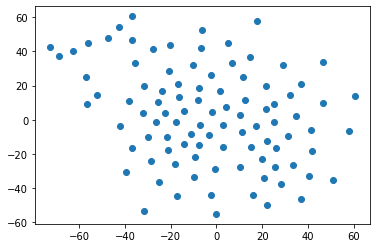

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

In [0]:
from sklearn.decomposition import PCA

In [0]:
cluster_data_std.shape

(96, 1024)

In [0]:
pca = PCA(n_components=50)
cluster_data_pca = pca.fit_transform(cluster_data_std)

In [0]:
cluster_data_pca.shape

(96, 50)

In [0]:
X_embedded = TSNE(n_components=2, perplexity = 20).fit_transform(cluster_data_pca)

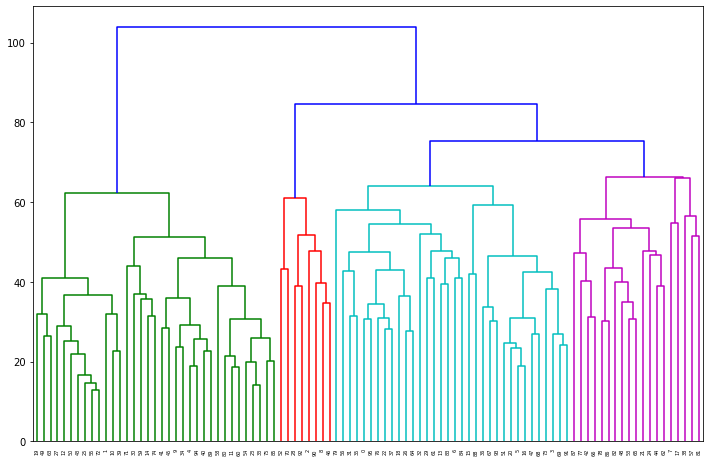

In [0]:
linked = linkage(cluster_data_pca, method = 'ward')
fig = plt.figure(figsize = (12,8))
dendrogram(linked,
            orientation='top',
            #labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [0]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
clusters = cluster.fit_predict(cluster_data_pca)

In [0]:
data.classes

['embankment', 'flood_gate', 'flood_wall', 'outfall', 'reservoir']

In [0]:
linked.shape

(95, 4)

In [0]:
linked

array([[ 55.      ,  72.      ,  12.949804,   2.      ],
       [ 23.      ,  33.      ,  13.995639,   2.      ],
       [ 25.      ,  96.      ,  14.601877,   3.      ],
       [ 43.      ,  98.      ,  16.750368,   4.      ],
       ...,
       [179.      , 186.      ,  66.289138,  19.      ],
       [185.      , 187.      ,  75.394363,  53.      ],
       [183.      , 188.      ,  84.540449,  61.      ],
       [184.      , 189.      , 103.863617,  96.      ]])

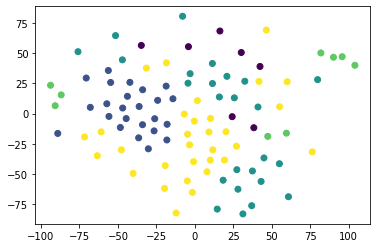

In [0]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clusters)